## Figure 7

Bar chart showing a) LWP, b) effective radius, and c) cloud albedo for different conditions. 

Bars divided into different climate conditions:
- slow vs. fast updraft: w
- clean vs. polluted environment: Na
- large vs. small aerosol: ra
- organic rich vs. poor: Forg

and different bars for each assumption of surface partitioning, including constant surface tension. 

In [1]:
import sys
if 'google.colab' in sys.modules:
    !pip --quiet install "open_atmos_jupyter_utils"
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples')

In [12]:
import numpy as np
import os
from joblib import Parallel, delayed
import pickle as pkl

from matplotlib import pyplot
from matplotlib.colors import TwoSlopeNorm
from open_atmos_jupyter_utils import show_plot

from PySDM import Formulae
from PySDM.physics import si
from PySDM.initialisation.sampling import spectral_sampling as spec_sampling

from PySDM_examples.Singer_Ward import Settings, ParcelSimulation
from PySDM_examples.Singer_Ward.aerosol import AerosolBetaCaryophylleneDark
from PySDM_examples.Singer_Ward.constants_def import SINGER_CONSTS, plot_colors, plot_lines, plot_names

import warnings
from numba.core.errors import NumbaExperimentalFeatureWarning

In [52]:
CI = 'CI' in os.environ

save = True
restore_saved_data = False

# updrafts = (0.1, 5)
# aerosol_number_concs = (50, 200)
# aerosol_mean_radii = (50, 100)
# forgs =(0.2, 0.8)
conditions = ("slow", "fast", "clean", "polluted", "small", "large", "poor", "rich")
models = ('Constant', 'CompressedFilmOvadnevaite', 'SzyszkowskiLangmuir', 'CompressedFilmRuehl')

def c2p(c):
    match c:
        case "slow":
            w = 0.1
            N_a = 200
            r_a = 50
            Forg = 0.5
        case "fast":
            w = 5
            N_a = 200
            r_a = 50
            Forg = 0.5
        case "clean":
            w = 0.5
            N_a = 50
            r_a = 50
            Forg = 0.5
        case "polluted":
            w = 0.5
            N_a = 400
            r_a = 50
            Forg = 0.5
        case "small":
            w = 0.5
            N_a = 200
            r_a = 30
            Forg = 0.5
        case "large":
            w = 0.5
            N_a = 200
            r_a = 80
            Forg = 0.5
        case "poor":
            w = 0.5
            N_a = 200
            r_a = 50
            Forg = 0.2
        case "rich":
            w = 0.5
            N_a = 200
            r_a = 50
            Forg = 0.8

    return {"w":w, "N_a":N_a, "r_a":r_a, "Forg":Forg}

FORMULAE = Formulae(constants=SINGER_CONSTS)
# WATER_MOLAR_VOLUME = FORMULAE.constants.water_molar_volume
WATER_MOLAR_VOLUME = FORMULAE.constants.Mv / FORMULAE.constants.rho_w

In [56]:
# def genkey(w, Forg, N_a, r_a, model):
#     return f"w{w:.2f}_f{Forg:.2f}_N{N_a:.2f}_r{r_a:.2f}_{model}"

if restore_saved_data:
    with open('data_fig7.pkl','rb') as file:
        output = pkl.load(file)
else:
    def compute(key, settings):
        simulation = ParcelSimulation(settings)
        output = simulation.run()
        model = key.split("_")[-1]
        output['updraft'] = settings.w
        output['org_fraction'] = settings.aerosol.modes[0]['f_org']
        output['color'] = plot_colors[model]
        return key, output

    print(f'tasks scheduled: {len(models) * len(conditions)}')
    output = dict(Parallel(verbose=10, n_jobs=-1)(
        delayed(compute)(f"{cond}_{model}", Settings(
            dz = 1 * si.m,
            n_sd_per_mode = 100,
            model = model,
            aerosol = AerosolBetaCaryophylleneDark(
                water_molar_volume=WATER_MOLAR_VOLUME,
                Forg=c2p(cond)["Forg"],
                N_a=c2p(cond)["N_a"],
                r_a=c2p(cond)["r_a"]
            ),
            w = c2p(cond)["w"] * si.m / si.s,
            spectral_sampling = spec_sampling.ConstantMultiplicity,
        ))
        for cond in conditions
        for model in models
    ))

    if save:
        with open('data_fig7.pkl','wb') as file:
            pkl.dump(output, file)

tasks scheduled: 32


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


slow_Constant
slow_CompressedFilmOvadnevaite
slow_SzyszkowskiLangmuir
slow_CompressedFilmRuehl
fast_Constant
fast_CompressedFilmOvadnevaite
fast_SzyszkowskiLangmuir
fast_CompressedFilmRuehl
clean_Constant


[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.1min


clean_CompressedFilmOvadnevaite
clean_SzyszkowskiLangmuir
clean_CompressedFilmRuehl
polluted_Constant
polluted_CompressedFilmOvadnevaite
polluted_SzyszkowskiLangmuir
polluted_CompressedFilmRuehl


[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min


small_Constant
small_CompressedFilmOvadnevaite
small_SzyszkowskiLangmuir
small_CompressedFilmRuehl
large_Constant
large_CompressedFilmOvadnevaite
large_SzyszkowskiLangmuir


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.7min


large_CompressedFilmRuehl
poor_Constant
poor_CompressedFilmOvadnevaite
poor_SzyszkowskiLangmuir
poor_CompressedFilmRuehl


[Parallel(n_jobs=-1)]: Done  21 out of  32 | elapsed:  3.3min remaining:  1.7min


rich_Constant
rich_CompressedFilmOvadnevaite
rich_SzyszkowskiLangmuir
rich_CompressedFilmRuehl


[Parallel(n_jobs=-1)]: Done  25 out of  32 | elapsed:  3.8min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  29 out of  32 | elapsed:  4.2min remaining:   26.3s
[Parallel(n_jobs=-1)]: Done  32 out of  32 | elapsed:  4.6min finished


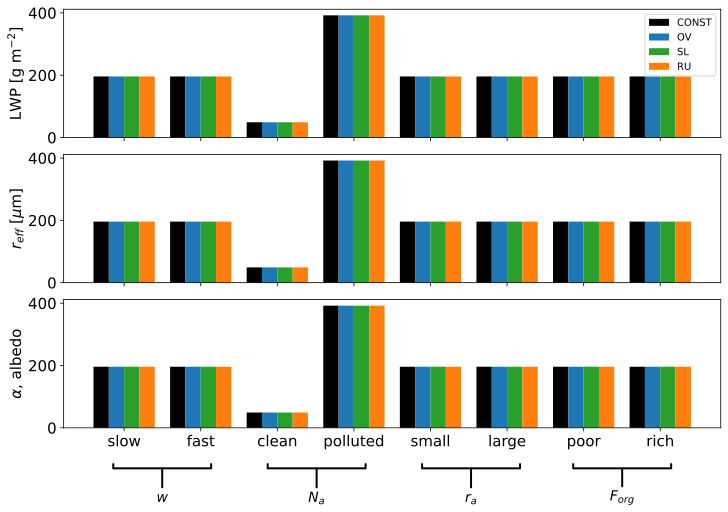

HTML(value="<a href='./fig7.pdf' target='_blank'>./fig7.pdf</a><br>")

In [108]:
fig, axes = pyplot.subplots(3, 1, figsize=(10, 7), sharex=True, constrained_layout=True)
pyplot.rcParams.update({"font.size":15})

bar_width = 0.1
# vars = ("lwp", "reff", "albedo")
labels = ("LWP [g m$^{-2}$]", "$r_{eff}$ [$\mu$m]", "$\\alpha$, albedo")

vars = ("CDNC", "CDNC", "CDNC")

x_cond = {"slow":0, "fast":1, "clean":2, "polluted":3, "small":4, "large":5, "poor":6, "rich":7}
x_model = {'Constant':0, 'CompressedFilmOvadnevaite':1, 'SzyszkowskiLangmuir':2, 'CompressedFilmRuehl':3}


for i, ax in enumerate(axes):
    for key, output_k in output.items():
        cond, model = key.split("_")

        cloud_top_index = -1
        x = x_cond[cond]*5*bar_width + x_model[model]*bar_width + bar_width/2

        if cond == "slow":
            ax.bar(x, output_k[vars[i]][cloud_top_index], color=plot_colors[model], width=bar_width, label=plot_names[model])
        else:
            ax.bar(x, output_k[vars[i]][cloud_top_index], color=plot_colors[model], width=bar_width)

        ax.set_xticks([x_cond[cond]*5*bar_width + 2*bar_width for cond in conditions])
        ax.set_xticklabels(conditions)

    ax.set_ylabel(labels[i])
    if i == 0:
        ax.legend(fontsize=10)

    yoffset = -0.3
    if i == 2:
        ax.annotate('$w$', xy=(0.3*5*bar_width, yoffset), xytext=(0.3*5*bar_width, 2*yoffset),
            fontsize=14, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

        ax.annotate('$N_a$', xy=(0.77*5*bar_width, yoffset), xytext=(0.77*5*bar_width, 2*yoffset),
            fontsize=14, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

        ax.annotate('$r_a$', xy=(1.24*5*bar_width, yoffset), xytext=(1.24*5*bar_width, 2*yoffset),
            fontsize=14, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

        ax.annotate('$F_{org}$', xy=(1.7*5*bar_width, yoffset), xytext=(1.7*5*bar_width, 2*yoffset),
            fontsize=14, ha='center', va='bottom', xycoords='axes fraction', 
            arrowprops=dict(arrowstyle='-[, widthB=3.5, lengthB=.3', lw=2.0))

show_plot("fig7.pdf")